<a href="https://colab.research.google.com/github/1bensupriatma/GenerativeAI/blob/main/HW6/ExtraCredit/Extra_Credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install musescore
!apt-get install music21
!apt-get install fluidsynth


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  desktop-file-utils fonts-freefont-ttf libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0
  libmtdev1 libportaudio2 libportmidi0 libqt5core5a libqt5dbus5 libqt5gui5 libqt5help5
  libqt5network5 libqt5printsupport5 libqt5qml5 libqt5qmlmodels5 libqt5qmlworkerscript5
  libqt5quick5 libqt5sql5 libqt5sql5-sqlite libqt5svg5 libqt5widgets5 libqt5xml5 libqt5xmlpatterns5
  libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1 libxkbcommon-x11-0
  musescore-common musescore-general-soundfont-small qml-module-qt-labs-folderlistmodel
  qml-module-qt-labs-settings qml-module-qtgraphicaleffects qml-module-qtqml
  qml-module-qtqml-models2 qml-module-qtquick-controls qml-module-qtquick-dialogs
  qml-module-qtquick-layouts qml-module-qtquick

In [3]:
import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

In [4]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "/content/data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

In [5]:
# Load the data
file_list = glob.glob("/content/data/*.mid")
print(f"Found {len(file_list)} midi files")

parser = music21.converter

example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

Found 32 midi files


In [6]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x7c8866c01330>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Piano 'JV-1080 Piano 1: JV-1080 Piano 1'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=150>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord C4>
    {1.0} <music21.note.Rest quarter>
    {2.0} <music21.chord.Chord B-3>
    {2.25} <music21.chord.Chord B-3 C4>
    {2.6667} <music21.chord.Chord C4>
    {3.0} <music21.chord.Chord E-4>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord C4>
    {1.0} <music21.chord.Chord B-3>
    {1.25} <music21.chord.Chord B-3 C4>
    {1.5} <music21.chord.Chord C4>
    {2.0} <music21.chord.Chord C4 F4>
    {2.25} <music21.chord.Chord F4>
    {3.0} <music21.chord.Chord B-3>
{8.0} <music21.stream.Measure 3 offset=8.0>
    {0.0} <music21.chord.Chord B-3>
    {0.25} <music21.chord.Chord B-3 C4>
    {0.6667} <music21.chord.Chord C4>
    {1.0} <m

In [7]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing /content/data/Flute Pluggnb 1.mid
48 notes parsed
2 Parsing /content/data/Lead Pluggnb 18 Saiko.mid
106 notes parsed
3 Parsing /content/data/String R&B 1.mid


<ipython-input-7-04172d0f16ff>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


120 notes parsed
4 Parsing /content/data/Flute Dr Eggman.mid
180 notes parsed
5 Parsing /content/data/Violin Melody 1.mid
263 notes parsed
6 Parsing /content/data/Guitar Pluggnb 3.mid
357 notes parsed
7 Parsing /content/data/Lead R&B Passion.mid
425 notes parsed
8 Parsing /content/data/Guitar Plugg Background.mid
464 notes parsed
9 Parsing /content/data/Flute Crying.mid
502 notes parsed
10 Parsing /content/data/Lead Melody Pluggnb.mid
552 notes parsed
11 Parsing /content/data/Guitar Jam 1.mid
611 notes parsed
12 Parsing /content/data/Lead Pluggnb 20 Bluemoon.mid
660 notes parsed
13 Parsing /content/data/Lead Plugg 5.mid
714 notes parsed
14 Parsing /content/data/Oboe Devine.mid
787 notes parsed
15 Parsing /content/data/Bell Melody 1.mid
821 notes parsed
16 Parsing /content/data/Oboe 2.mid
843 notes parsed
17 Parsing /content/data/Lead Pluggnb 17 Better Off Alone.mid
908 notes parsed
18 Parsing /content/data/Flute Ninja Style.mid
979 notes parsed
19 Parsing /content/data/Lead Pluggnb 19 

In [8]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 F4 rest START 4/4TS rest F5 G5 G5 C5 rest E-5 F5 F5 F5 F5 G5 G5 F5 rest E-5 F5 F5 F5 rest rest B-4 C5 rest G4 F5 G5 G5 C5 rest E-5 F5 F5 F5 F5 G5 G5 B-4 C5 E-5 F5 F5 F5 F4 rest rest E-5 ...

Duration string
 5/3 1.5 0.0 0.0 1.0 1/3 1/6 0.5 0.75 0.25 0.5 0.25 0.25 1.0 1/3 1/6 0.5 0.75 0.25 0.5 0.25 0.25 2.0 2.0 2.5 0.25 0.75 0.5 1.0 1/3 1/6 0.5 0.75 0.25 0.5 0.25 0.25 1.0 1/3 1/6 0.5 0.25 0.75 0.5 0.25 0.25 1/6 31/12 1.25 2.0 0.5 ...


In [9]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))


In [10]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
         7        24
         2        13
        24         8
        22         8
         2         4
        12         5
        25         7
        25         3
        10         6
         2         2
        20         3


In [11]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 38
0: 
1: [UNK]
2: rest
3: A4
4: E4
5: G4
6: D4
7: F4
8: B-4
9: C4

DURATIONS_VOCAB: length = 33
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/6
8: 0.0
9: 1/12


In [12]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [13]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 8,  7,  2, ..., 11, 16, 29],
       [ 7,  2,  5, ..., 16, 29, 29],
       [ 2,  5,  7, ..., 29, 29, 16],
       ...,
       [20, 12, 12, ..., 31,  5,  5],
       [12, 12, 20, ...,  5,  5,  9],
       [12, 20, 13, ...,  5,  9,  6]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 8,  8,  4, ..., 15,  8,  8],
       [ 8,  4,  4, ...,  8,  8,  4],
       [ 4,  4,  4, ...,  8,  4,  4],
       ...,
       [ 7,  9,  2, ...,  7,  7,  3],
       [ 9,  2,  7, ...,  7,  3,  5],
       [ 2,  7,  7, ...,  3,  5,  5]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 7,  2,  5, ..., 16, 29, 29],
       [ 2,  5,  7, ..., 29, 29, 16],
       [ 5,  7,  7, ..., 29, 16, 16],
       ...,
       [12, 12, 20, ...,  5,  5,  9],
       [12, 20, 13, ...,  5,  9,  6],
       [20, 13, 13, ...,  9,  6,  5]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[8, 4, 4, ..., 8, 8, 4],
       [4, 4, 4, ..., 8, 4, 4],
       

In [14]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

In [15]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

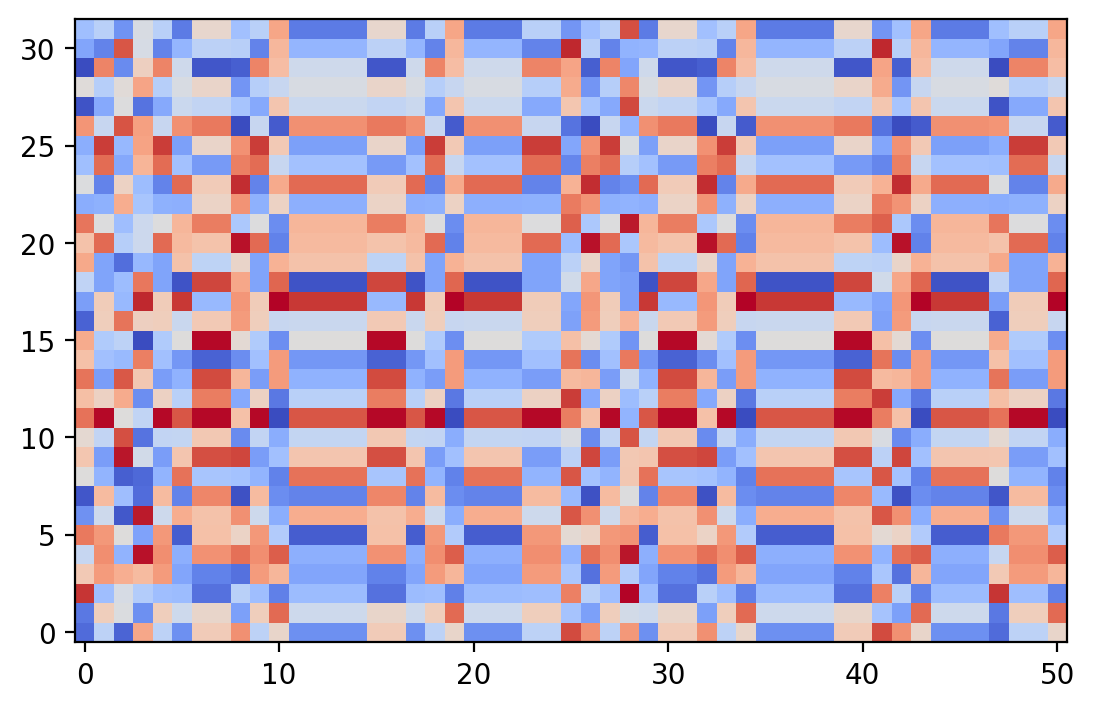

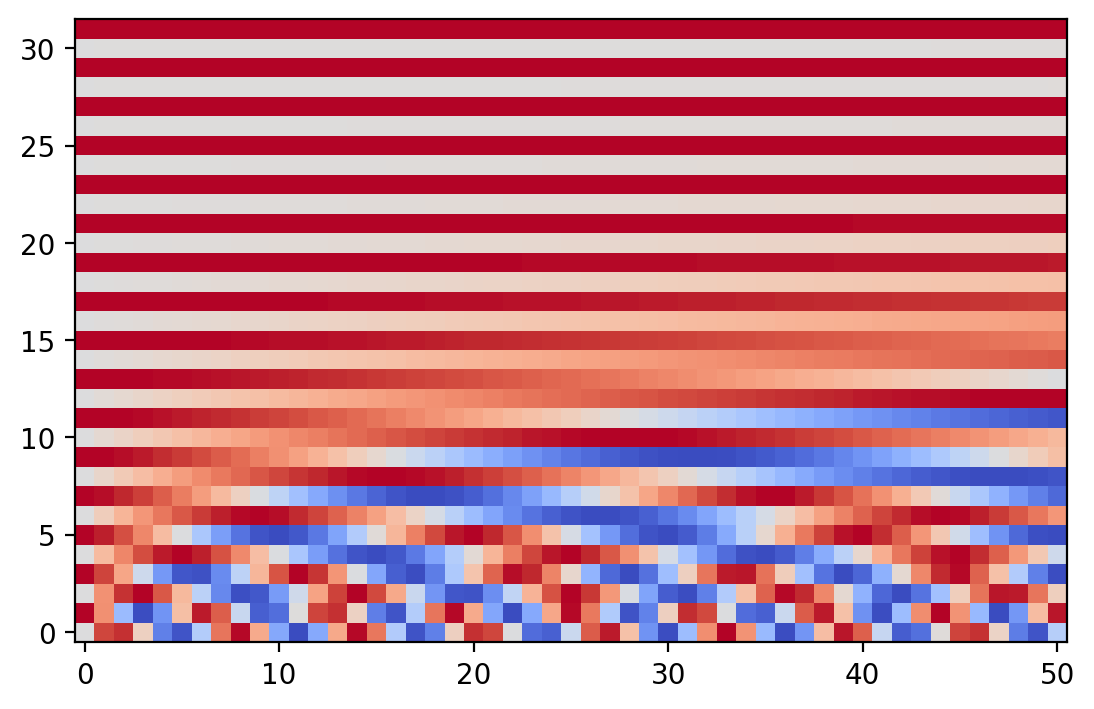

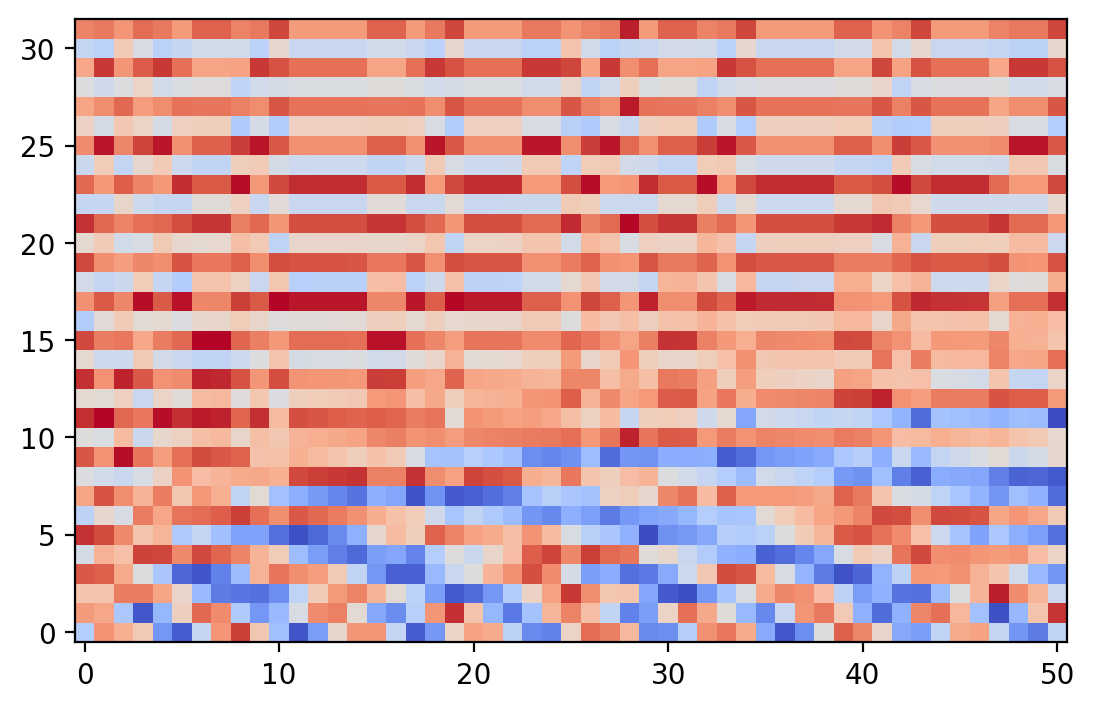

In [16]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

In [17]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          4,864 │ input_layer[0][0]      │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          4,224 │ input_layer_1[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 256)      │              0 │ token_and_position_em… │
│                           │                        │                │ token_and_position_em… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention                 │ [(None, None, 256),    │      1,447,424 │ concatenate[0][0]      │
│ (TransformerBlock)        │ (None, 5, None, None)] │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ note_outputs (Dense)      │ (None, None, 38)       │          9,766 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration_outputs (Dense)  │ (None, None, 33)       │          8,481 │ attention[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,474,759 (5.63 MB)

 Trainable params: 1,474,759 (5.63 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    #def on_epoch_end(self, epoch, logs=None):
     #   info = self.generate(
      #      ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
       # )
        # midi_stream = info[-1]["midi"].chordify()
        #  print(info[-1]["prompt"])
        #  midi_stream.show()
        #  midi_stream.write(
       #     "midi",
        #    fp=os.path.join(
         #       "/content/output",
          #      "output-" + str(epoch).zfill(4) + ".mid",
           # ),
        #)
# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [19]:
model.fit(
    ds,
    epochs=100,
    callbacks=[
        music_generator,
    ],
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - duration_outputs_loss: 3.6982 - loss: 7.9414 - note_outputs_loss: 4.2431
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - duration_outputs_loss: 2.4404 - loss: 5.8755 - note_outputs_loss: 3.4351
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - duration_outputs_loss: 2.3425 - loss: 5.6809 - note_outputs_loss: 3.3383
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - duration_outputs_loss: 2.3486 - loss: 5.5739 - note_outputs_loss: 3.2254
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - duration_outputs_loss: 2.2883 - loss: 5.4804 - note_outputs_loss: 3.1922
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - duration_outputs_loss: 2.1890 - loss: 5.3528 - note_outputs_loss: 3.1637
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - duration_outputs_loss: 2.0653 - loss: 5.1181 - note_outputs_loss: 3.0527
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - duration_outputs_loss: 2.2237 - loss: 5.1027 - note_outputs_loss: 2.8790

In [20]:
os.makedirs("content/model", exist_ok = True)
# Save the final model
model.save("/content/model.keras")

In [37]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.9
)
midi_stream = info[-1]["midi"].chordify()


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [38]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/content/transformer_output",
        "output-" + timestr + ".mid",
    ),
)

'/content/transformer_output/output-20241207-001042.mid'

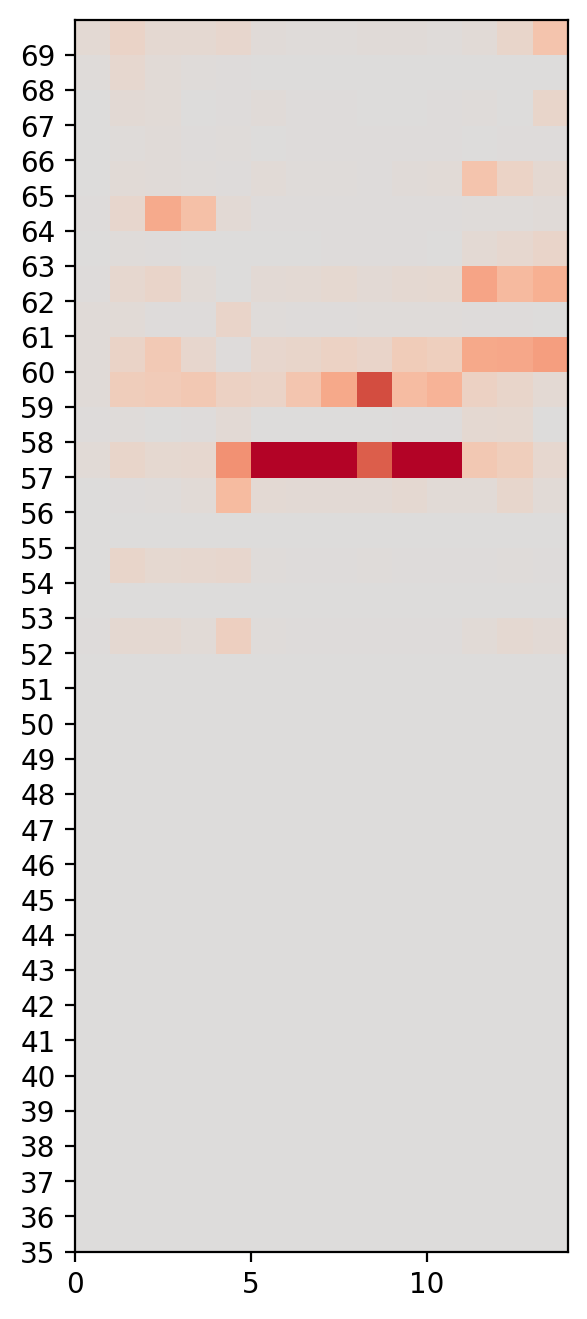

In [24]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

In [27]:
from google.colab import files
import shutil

shutil.make_archive("/content/model", 'zip', "my_folder")
shutil.make_archive("/content/output", 'zip', "my_folder")
shutil.make_archive("/content/transformer_output", 'zip', "my_folder")
shutil.make_archive("/content/data", 'zip', "my_folder")

from google.colab import drive
drive.mount('/content/drive')

# Saving the model and its data on the Google drive

!cp -r /content/data /content/drive/MyDrive/GenAI
!cp -r /content/model /content/drive/MyDrive/GenAI
!cp -r /content/output /content/drive/MyDrive/GenAI
!cp -r /content/transformer_output /content/drive/MyDrive/GenAI

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/content/model': No such file or directory
cp: cannot stat '/content/output': No such file or directory
